In [1]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0) 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-12 06:49:05.742533: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path1 = './IDRID/Original_Images/Training_Set'
# training masks directory
path2 = './IDRID/All_Segmentation_Groundtruths/Training_Set/Soft_Exudates'
patch_size = 512

In [3]:
image_dataset = []
images = sorted(os.listdir(path1)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]


In [4]:
len(image_dataset)

54

In [5]:
mask_dataset = []
images = sorted(os.listdir(path2)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path2 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 28.11it/s]


In [6]:
len(mask_dataset)

54

mporting models

In [7]:
from model import unetmodel, residualunet, attentionunet
from tensorflow.keras.optimizers import Adam
from evaluation_metrics import IoU_coef,IoU_loss
import tensorflow as tf

In [8]:
IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [9]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv
def inverted_residual_block(x, expand=64, squeeze=16, dropout=0, batchnorm=False):
    m = layers.Conv2D(expand, (1, 1), activation='relu')(x)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(m)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.Conv2D(squeeze, (1, 1), activation='relu')(m)
    if dropout > 0:
        m = layers.Dropout(dropout)(m)
    if x.shape[-1] != squeeze:
        x = layers.Conv2D(squeeze, (1, 1), activation='relu')(x)
    respath = layers.add([m, x])
    return respath

#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath

#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


def receptive_field_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    # Receptive field block
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    receptive_field = conv_block(pool, kernelsize, filters, dropout, batchnorm)
    upsampled_receptive_field = layers.UpSampling2D(size=(2, 2))(receptive_field)
    conv = layers.concatenate([conv, upsampled_receptive_field], axis=3)
    
    return conv


def unetmodel_residual(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers with receptive field blocks
    dn_1 = receptive_field_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = receptive_field_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = receptive_field_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = receptive_field_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = receptive_field_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(dn_5)
    up_conv_5 = inverted_residual_block(up_5, expand=filters[3], squeeze=filters[3], dropout=dropout, batchnorm=batchnorm)
    up_5 = layers.concatenate([up_conv_5, dn_4], axis=3)
    up_5 = layers.Conv2D(filters[0], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_5)

    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_5)
    up_conv_4 = inverted_residual_block(up_4, expand=filters[2], squeeze=filters[2], dropout=dropout, batchnorm=batchnorm)
    up_4 = layers.concatenate([up_conv_4,dn_3], axis=3)
    up_4 = layers.Conv2D(filters[1], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_4)

    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_4)
    up_conv_3 = inverted_residual_block(up_3, expand=filters[1], squeeze=filters[1], dropout=dropout, batchnorm=batchnorm)
    up_3 = layers.concatenate([up_conv_3,dn_2], axis=3)
    up_3 = layers.Conv2D(filters[2], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_3)

    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_3)
    up_conv_2 = inverted_residual_block(up_2, expand=filters[0], squeeze=filters[0], dropout=dropout, batchnorm=batchnorm)
    up_2 = layers.concatenate([up_conv_2, dn_1], axis=3)
    up_2 = layers.Conv2D(filters[3], (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(up_2)

    conv_final = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


In [10]:
from keras import backend as K
import tensorflow as tf
defined_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='dice_score'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='f1_score'),
]

2023-07-12 06:49:28.404696: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 06:49:29.050508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1133 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [11]:
model = unetmodel_residual(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= 'binary_crossentropy', metrics=defined_metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 32  9248        ['max_pooling2d_2[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 128, 32  128        ['conv2d_6[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_6 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_6[0][0]']  
                                )                                                                 
                                                                                                  
 dropout_3

 activation_12 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 dropout_6 (Dropout)            (None, 64, 64, 128)  0           ['activation_12[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 128)  147584      ['dropout_6[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 128)  512        ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_13[0][0]'] 
          

 v2D)                                                                                             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64, 64, 128)  512        ['depthwise_conv2d[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 64, 128)  16512       ['batch_normalization_21[0][0]'] 
                                                                                                  
 dropout_10 (Dropout)           (None, 64, 64, 128)  0           ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 128)  65664       ['up_sampling2d_5[0][0]']        
          

 conv2d_33 (Conv2D)             (None, 512, 512, 16  272         ['batch_normalization_27[0][0]'] 
                                )                                                                 
                                                                                                  
 dropout_13 (Dropout)           (None, 512, 512, 16  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 512, 512, 16  528         ['up_sampling2d_8[0][0]']        
                                )                                                                 
                                                                                                  
 add_3 (Add)                    (None, 512, 512, 16  0           ['dropout_13[0][0]',             
          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

In [14]:
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 1,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=200,
                    )

Epoch 1/200
36/37 [============================>.] - ETA: 0s - loss: 0.7178 - auc: 0.4965 - accuracy: 0.5949 - mean_iou: 0.4990 - dice_score: 0.4990 - f1_score: 0.4990

2023-07-12 06:50:04.593522: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 6s 138ms/step - loss: 0.7170 - auc: 0.4959 - accuracy: 0.5937 - mean_iou: 0.4991 - dice_score: 0.4991 - f1_score: 0.4991 - val_loss: 0.6678 - val_auc: 0.4236 - val_accuracy: 0.9201 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 2/200
37/37 [==============================] - 1s 35ms/step - loss: 0.6812 - auc: 0.4933 - accuracy: 0.7484 - mean_iou: 0.4991 - dice_score: 0.4991 - f1_score: 0.4991 - val_loss: 0.8283 - val_auc: 0.4248 - val_accuracy: 0.8838 - val_mean_iou: 0.4980 - val_dice_score: 0.4980 - val_f1_score: 0.4980
Epoch 3/200
37/37 [==============================] - 2s 49ms/step - loss: 0.6608 - auc: 0.4900 - accuracy: 0.8792 - mean_iou: 0.4991 - dice_score: 0.4991 - f1_score: 0.4991 - val_loss: 0.5640 - val_auc: 0.5061 - val_accuracy: 0.9884 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 4/200
37/37 [==============================] - 2s 47ms/step - loss: 0.6415 - auc: 0.5040 - ac

Epoch 28/200
37/37 [==============================] - 2s 44ms/step - loss: 0.3437 - auc: 0.5372 - accuracy: 0.9983 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.3384 - val_auc: 0.5229 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 29/200
37/37 [==============================] - 2s 44ms/step - loss: 0.3356 - auc: 0.5117 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.3296 - val_auc: 0.5054 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 30/200
37/37 [==============================] - 1s 40ms/step - loss: 0.3277 - auc: 0.5140 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.3212 - val_auc: 0.5146 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 31/200
37/37 [==============================] - 1s 36ms/step - loss: 0.3200 - a

Epoch 55/200
37/37 [==============================] - 2s 49ms/step - loss: 0.1878 - auc: 0.5755 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1876 - val_auc: 0.5389 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 56/200
37/37 [==============================] - 2s 60ms/step - loss: 0.1839 - auc: 0.5892 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1839 - val_auc: 0.4952 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 57/200
37/37 [==============================] - 1s 36ms/step - loss: 0.1804 - auc: 0.5854 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1798 - val_auc: 0.5259 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 58/200
27/37 [====================>.........] - ETA: 0s - loss: 0.1796 - auc: 0

2023-07-12 06:51:36.741473: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


35/37 [===========================>..] - ETA: 0s - loss: 0.1787 - auc: 0.5275 - accuracy: 0.9985 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992

2023-07-12 06:51:37.055418: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 1s 39ms/step - loss: 0.1786 - auc: 0.5286 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1921 - val_auc: 0.4979 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 59/200
37/37 [==============================] - 1s 40ms/step - loss: 0.1728 - auc: 0.5304 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1721 - val_auc: 0.5010 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 60/200
37/37 [==============================] - 2s 46ms/step - loss: 0.1693 - auc: 0.5100 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1690 - val_auc: 0.5254 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 61/200
37/37 [==============================] - 2s 56ms/step - loss: 0.1659 - auc: 0.5387 - 

2023-07-12 06:51:53.316527: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 1s 38ms/step - loss: 0.1444 - auc: 0.5256 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1445 - val_auc: 0.4931 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 69/200
37/37 [==============================] - 2s 43ms/step - loss: 0.1416 - auc: 0.5303 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1416 - val_auc: 0.4994 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 70/200
37/37 [==============================] - 2s 44ms/step - loss: 0.1389 - auc: 0.5526 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1391 - val_auc: 0.4935 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 71/200
37/37 [==============================] - 2s 54ms/step - loss: 0.1362 - auc: 0.5429 - 

2023-07-12 06:52:19.908028: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 2s 49ms/step - loss: 0.1049 - auc: 0.5494 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1065 - val_auc: 0.5211 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 86/200
37/37 [==============================] - 2s 55ms/step - loss: 0.1030 - auc: 0.5280 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1046 - val_auc: 0.5000 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 87/200
37/37 [==============================] - 1s 40ms/step - loss: 0.1012 - auc: 0.5035 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.1028 - val_auc: 0.5001 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 88/200
37/37 [==============================] - 1s 36ms/step - loss: 0.0994 - auc: 0.5511 - 

2023-07-12 06:52:27.584066: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 2s 47ms/step - loss: 0.0976 - auc: 0.5355 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0993 - val_auc: 0.5000 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 90/200
37/37 [==============================] - 2s 51ms/step - loss: 0.0959 - auc: 0.5008 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0975 - val_auc: 0.5000 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 91/200
37/37 [==============================] - 1s 37ms/step - loss: 0.0942 - auc: 0.5096 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0959 - val_auc: 0.5122 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 92/200
37/37 [==============================] - 1s 37ms/step - loss: 0.0926 - auc: 0.5691 - 

2023-07-12 06:52:49.824276: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 2s 45ms/step - loss: 0.0755 - auc: 0.5423 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0778 - val_auc: 0.5000 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 105/200
37/37 [==============================] - 1s 38ms/step - loss: 0.0743 - auc: 0.5092 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0766 - val_auc: 0.5001 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 106/200
37/37 [==============================] - 1s 38ms/step - loss: 0.0731 - auc: 0.5250 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0754 - val_auc: 0.5070 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 107/200
37/37 [==============================] - 2s 53ms/step - loss: 0.0719 - auc: 0.6370

2023-07-12 06:53:16.675513: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 1s 37ms/step - loss: 0.0585 - auc: 0.5903 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0617 - val_auc: 0.5057 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 121/200
37/37 [==============================] - 2s 48ms/step - loss: 0.0576 - auc: 0.6344 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0607 - val_auc: 0.5443 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 122/200
37/37 [==============================] - 2s 45ms/step - loss: 0.0568 - auc: 0.6914 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0602 - val_auc: 0.5295 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 123/200
37/37 [==============================] - 2s 52ms/step - loss: 0.0559 - auc: 0.7340

2023-07-12 06:53:27.450588: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-12 06:53:27.471013: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-12 06:53:27.492525: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


37/37 [==============================] - 2s 47ms/step - loss: 0.0526 - auc: 0.6820 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0557 - val_auc: 0.5312 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 128/200
37/37 [==============================] - 2s 51ms/step - loss: 0.0519 - auc: 0.7165 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0548 - val_auc: 0.5212 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 129/200
37/37 [==============================] - 1s 39ms/step - loss: 0.0511 - auc: 0.7682 - accuracy: 0.9984 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0543 - val_auc: 0.5098 - val_accuracy: 0.9974 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 130/200
37/37 [==============================] - 1s 37ms/step - loss: 0.0503 - auc: 0.7678

Epoch 154/200
37/37 [==============================] - 1s 33ms/step - loss: 0.0345 - auc: 0.9670 - accuracy: 0.9985 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0400 - val_auc: 0.6005 - val_accuracy: 0.9973 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 155/200
37/37 [==============================] - 1s 35ms/step - loss: 0.0339 - auc: 0.9523 - accuracy: 0.9985 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0378 - val_auc: 0.5551 - val_accuracy: 0.9973 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 156/200
37/37 [==============================] - 1s 36ms/step - loss: 0.0333 - auc: 0.9654 - accuracy: 0.9985 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0385 - val_auc: 0.6053 - val_accuracy: 0.9973 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 157/200
37/37 [==============================] - 1s 38ms/step - loss: 0.0328

Epoch 181/200
37/37 [==============================] - 1s 38ms/step - loss: 0.0226 - auc: 0.9882 - accuracy: 0.9988 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0310 - val_auc: 0.5890 - val_accuracy: 0.9971 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 182/200
37/37 [==============================] - 1s 34ms/step - loss: 0.0225 - auc: 0.9790 - accuracy: 0.9988 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0289 - val_auc: 0.6386 - val_accuracy: 0.9970 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 183/200
37/37 [==============================] - 2s 49ms/step - loss: 0.0222 - auc: 0.9885 - accuracy: 0.9987 - mean_iou: 0.4992 - dice_score: 0.4992 - f1_score: 0.4992 - val_loss: 0.0351 - val_auc: 0.6119 - val_accuracy: 0.9948 - val_mean_iou: 0.4987 - val_dice_score: 0.4987 - val_f1_score: 0.4987
Epoch 184/200
37/37 [==============================] - 2s 50ms/step - loss: 0.0218

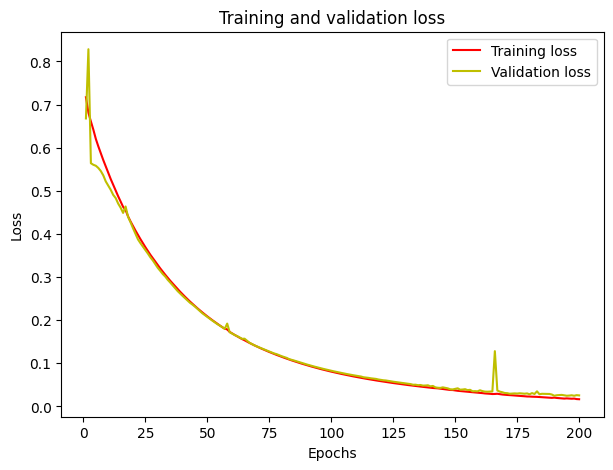

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

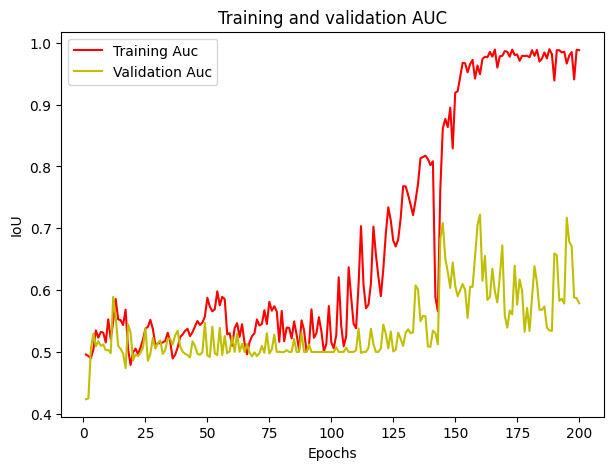

In [16]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure(figsize=(7,5))
plt.plot(epochs, auc, 'r', label='Training Auc')
plt.plot(epochs, val_auc, 'y', label='Validation Auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [17]:
model.save('./SE_models/Soft_Exudates_unetmodel_ive.h5')

In [18]:
model = tf.keras.models.load_model('./SE_models/Soft_Exudates_unetmodel_ive.h5')

In [19]:
# test dataset images directory path
path3 = './IDRID/Original_Images/Testing_Set'
# test dataset mask directory path
path4 = './IDRID/All_Segmentation_Groundtruths/Testing_Set/Soft_Exudates'

In [20]:
testimages = sorted(os.listdir(path3))
testmasks =  sorted(os.listdir(path4))

In [21]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0)

image_dataset = []
images = sorted(os.listdir(path3)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path3+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.39it/s]


In [22]:
len(image_dataset)

27

In [23]:
mask_dataset = []
images = sorted(os.listdir(path4)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path4 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
test_image_dataset = np.expand_dims(image_dataset,axis=-1)
test_mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.28it/s]


In [24]:
len(test_mask_dataset)

27

In [ ]:
import matplotlib.pyplot as plt

# Assuming val_pred is a NumPy array containing the predicted images

num_images = test_mask_dataset.shape[0]  # Get the number of predicted images

# Create a grid of subplots to display the images
rows = int(num_images / 4) + 1
fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))

# Iterate over the predicted images and plot them
for i in range(num_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(test_mask_dataset[i])
    ax.axis('off')

# Remove any empty subplots if the number of images is not a multiple of 4
if num_images % 4 != 0:
    for i in range(num_images % 4, 4):
        axes[-1, i].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_image_dataset, test_mask_dataset, batch_size=1)
print("test loss, test auc:", results)

Evaluate on test data
27/27 [==============================] - 2s 19ms/step - loss: 0.0230 - auc: 0.4943 - accuracy: 0.9978 - mean_iou: 0.4991 - dice_score: 0.4991 - f1_score: 0.4991
test loss, test auc: [0.023030590265989304, 0.49434444308280945, 0.9978123307228088, 0.4990963339805603, 0.4990963339805603, 0.4990963339805603]


In [26]:
val_pred = model.predict(test_image_dataset, batch_size=1)

27/27 [==============================] - 1s 7ms/step


In [27]:
val_pred  

array([[[[0.0137838 ],
         [0.01384716],
         [0.01397478],
         ...,
         [0.01426578],
         [0.01428064],
         [0.01428807]],

        [[0.01377927],
         [0.01385129],
         [0.01399646],
         ...,
         [0.01430172],
         [0.01431571],
         [0.01432271]],

        [[0.01377021],
         [0.01385954],
         [0.01403992],
         ...,
         [0.01437387],
         [0.01438612],
         [0.01439225]],

        ...,

        [[0.01385573],
         [0.0140101 ],
         [0.01432395],
         ...,
         [0.01441019],
         [0.01435858],
         [0.01433283]],

        [[0.01386079],
         [0.01398123],
         [0.01422523],
         ...,
         [0.01436408],
         [0.01435213],
         [0.01434617]],

        [[0.01386332],
         [0.01396682],
         [0.01417613],
         ...,
         [0.01434107],
         [0.01434892],
         [0.01435284]]],


       [[[0.01378192],
         [0.01384511],
         [0.01

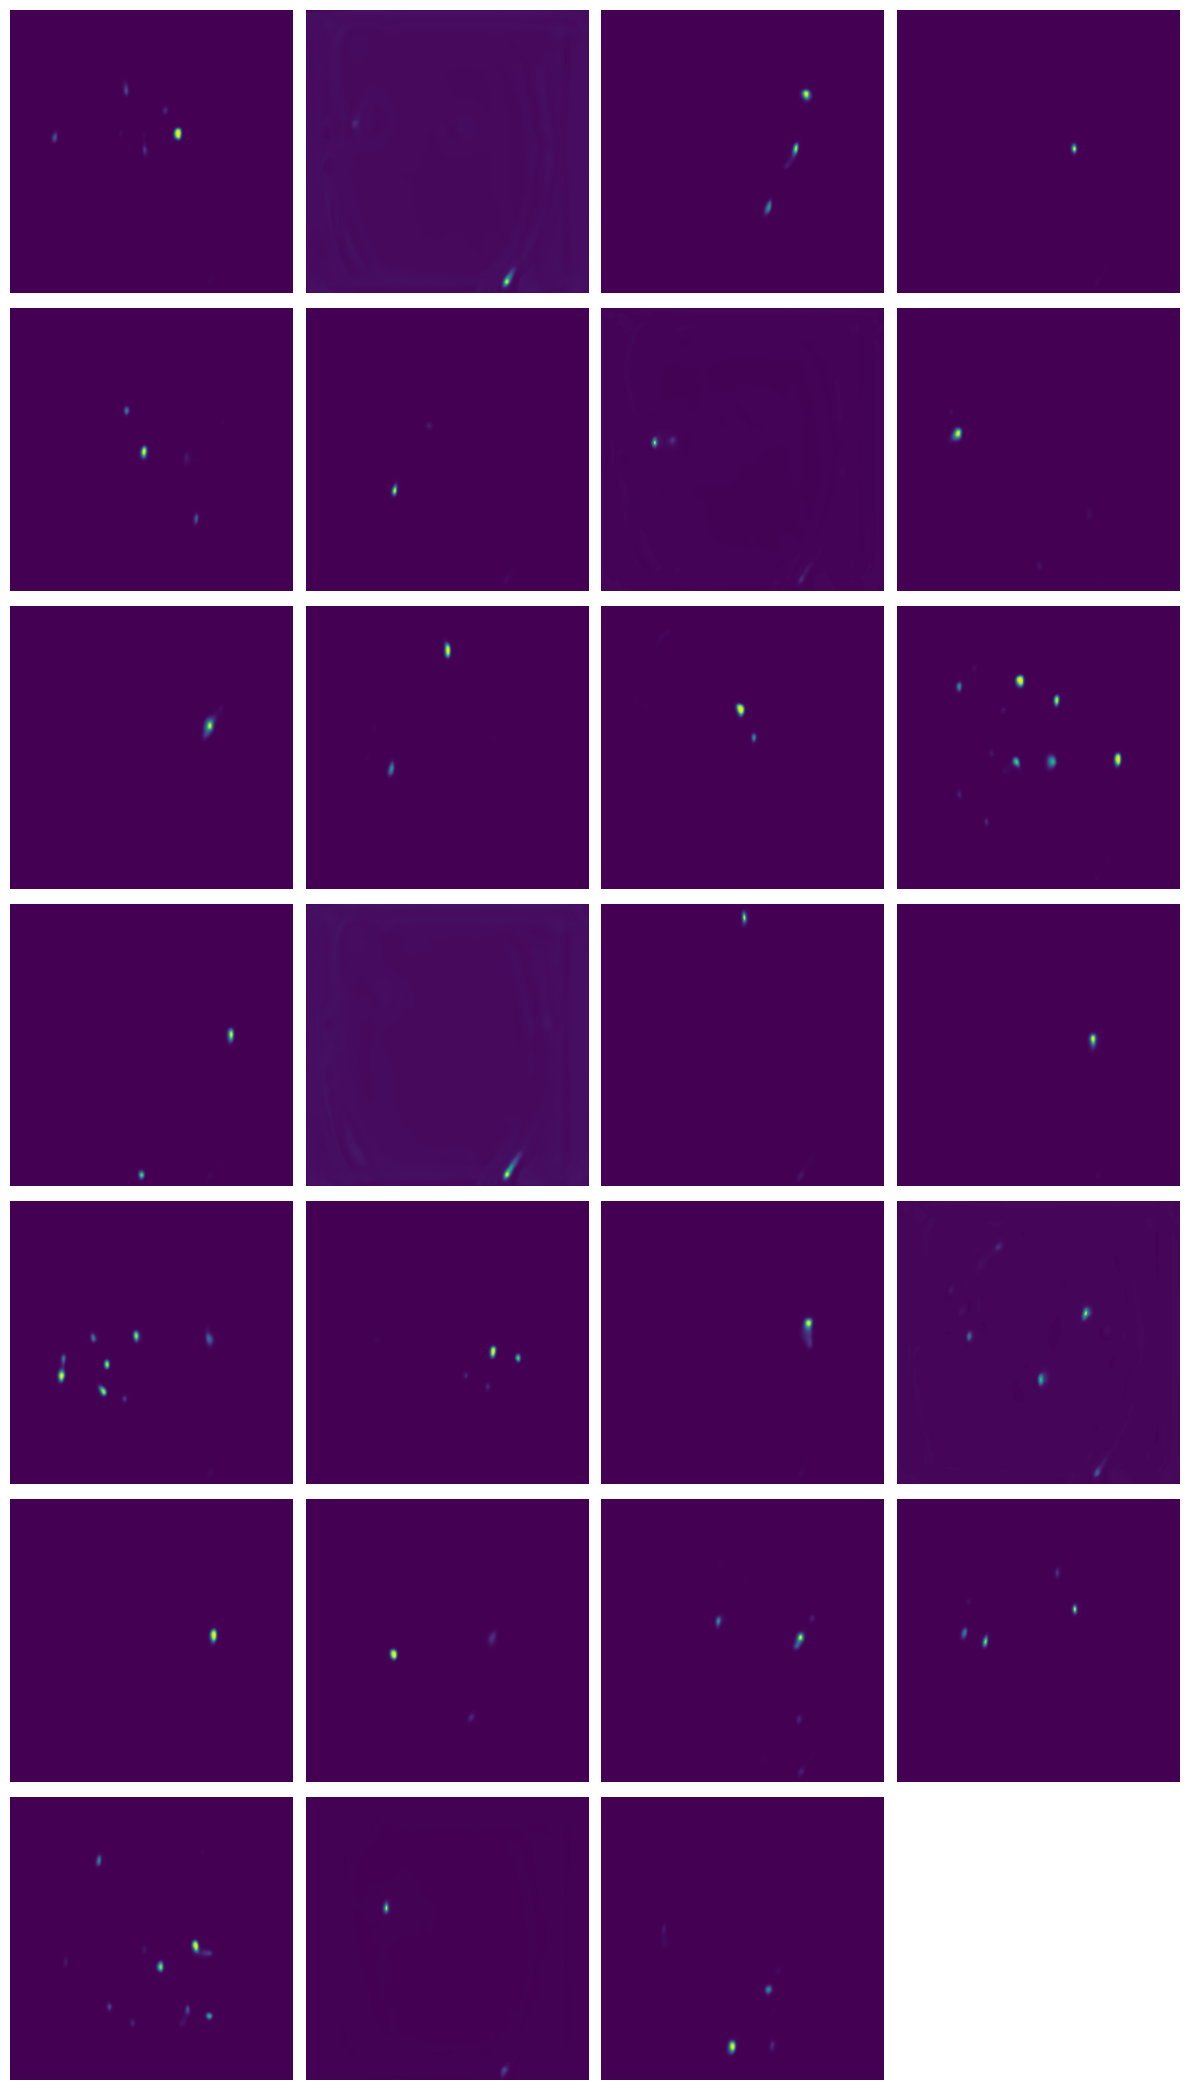

In [28]:
import matplotlib.pyplot as plt

# Assuming val_pred is a NumPy array containing the predicted images

num_images = val_pred.shape[0]  # Get the number of predicted images

# Create a grid of subplots to display the images
rows = int(num_images / 4) + 1
fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))

# Iterate over the predicted images and plot them
for i in range(num_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(val_pred[i])
    ax.axis('off')

# Remove any empty subplots if the number of images is not a multiple of 4
if num_images % 4 != 0:
    for i in range(num_images % 4, 4):
        axes[-1, i].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [29]:
for i in range (val_pred.shape[0]) :
    print(i,np.sum(val_pred[i,:,:,:]))

0 4012.2078
1 3761.2869
2 4025.9475
3 3805.119
4 3933.1084
5 3821.436
6 3765.4673
7 3881.936
8 3839.3237
9 3965.5576
10 3980.9202
11 4475.1733
12 3893.0652
13 3760.3472
14 3778.273
15 3880.6514
16 4260.014
17 3940.3518
18 3934.3672
19 3773.8765
20 3924.0708
21 3939.753
22 3825.3564
23 3850.4272
24 4160.0366
25 3770.5251
26 3960.453
